# Tweaking figures 
### [RN] 20210212

Need to tweak some figures for paper. 

one with lag = 300, k = 0.15; other with lag = 300, k = 0.17

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

plt.rcParams['figure.figsize'] = [14, 6]

In [25]:
### code from 20210202_TuesdayMeeting to get raw data into arrays. 

def ReadFile(infile): # read infile, return contents list of each line
    read = open(infile, 'r')
    lines = read.readlines()
    read.close()
    return(lines)
# read raw data
raw = ReadFile("USA-California.tsv")

def TryFloat(val): # I want to convert nonempty data points to either floats or none so I can operate on these arrays. 
    try:
        val = float(val)
    except:
        val = None
    return val
        
# extract data 
date, cases, deaths, hospital, icu, recovered = [], [], [], [], [], []

for i in range(4, len(raw)): # split up raw data. it looks like there are bytes  b'\t' that seprate vals in addition to end characters. 
    thisset = raw[i]
    thisset = thisset.encode('utf-8') # encode data as bytes
    working = thisset.split(b'\t') # split data by byte
    for i in range(len(working)):
        working[i] = working[i].decode('utf8', 'strict') # put back as string for easier handling 
    date.append(working[0])
    cases.append(TryFloat(working[1]))
    deaths.append(TryFloat(working[2]))
    hospital.append(TryFloat(working[3]))
    icu.append(TryFloat(working[4]))
    recovered.append(working[5])


In [26]:
## final function. 

"""
Input arguements 
I0 : initial number of infected peopl e
N : population size 
k : number of people each infected person infects 
g : removal rate from infectious pool 
v : maximum number of vaccines that will be given per day, limited by manufacturing and dispersal (after development)
lag : Number of days after patient 0, or day 0, after which vaccine becomes available
A : Anti vax population, or a percent of the population that will refuse the vaccine 
d : death rate, or percept of recovered people who are actually dead and removed completely 
w : number of days after infection that a person is temporarily immune and in recovered pool before being moved back to susceptible
r : number of days it takes to rollout vaccine at half maximum capacity
dt : time step. this is moderately sensitive to time step, see 20210205 notebook 
duration : number of days that should be modeled 

Outputs (arrays indexed by time): 
S : population susceptible to infection, and viable for vaccination 
I : Infected population 
R : recovered population, temporarily immine and viable for vaccination 
H : immune population, shows herd immunity through vaccination. Once vaccinated you are permanently immune by this extension
D : Dead population 
"""
def SIRHD(I0, N, k, g, v, lag, r, A, d, w, dt, duration): # susceptible, infected, temporarily immune, dead, herd immune
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R, H, D = np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    IPD = np.zeros(j) # infected per day
    R[0] = 0 # set initial values as given. 
    I[0] = I0
    S[0] = N-I0
    H[0] = 0 # starts with no people vaccinated
    D[0] = 0
    IPD[0] = 0
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt - (1/w)*R[i-1] * dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        if i*dt > lag:  # introduce number of days into pandemic it takes to get vaccinations going 
            since_vacc = i*dt -lag
            vr = v*(since_vacc)*(1/(r+since_vacc)) # the amount of people vaccined per day is more of a logarithmic increase rather than linear  
            if (S[i-1] + R[i-1]) < v: # if there are no unvaccinated people
                S[i-1] = A*N # only anti vaxxers remain susceptible 
                H[i-1] = N - S[i-1] - I[i-1] - R[i-1]-D[i-1] # now everyone is vaccinated! 
                dS = 0 # these stay constant 
                dH = 0
            else:
                pool = S[i-1] + R[i-1]
                wS = S[i-1]/pool # weight R and S groups to remove vaccined group
                wR = R[i-1]/pool # R and S people have equal probability of being vaccinated 
                dH = vr*dt
                dS = -(k/N) * S[i-1]*I[i-1]*dt - vr*dt*wS + (1/w)*R[i-1]*dt
                dR = dR - vr*dt*wR
        else: 
            dS = -(k/N) * S[i-1]*I[i-1]*dt + (1/w)*R[i-1]*dt
            dH = 0
        dD = I[i-1]*d*dt # amount of dead people in this time step 
        dR = dR - dD # remove dead population from initially calculated recovered 
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        D[i] = D[i-1]+dD
        S[i] = S[i-1]+dS
        H[i] = H[i-1]+dH # linearly remove vaccined population, which is limited by number of vaccines given per day
    return S, I, R, H, D # return S, I, and R arrays indexed by time.

def CheckTotal(S, I, R, H, D, N): 
    nonN = 0
    for i in range(len(S)):
        total = S[i] + I[i] + R[i] + H[i] + D[i]
        if N-total > 0.001*N:
            nonN = nonN+1
            print(N - total, i)
    if nonN == 0:
        return True # SIR all add up to N at any given time
    else:
        return False # something went wrong. total is not N.


/Users/rebeccanishide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


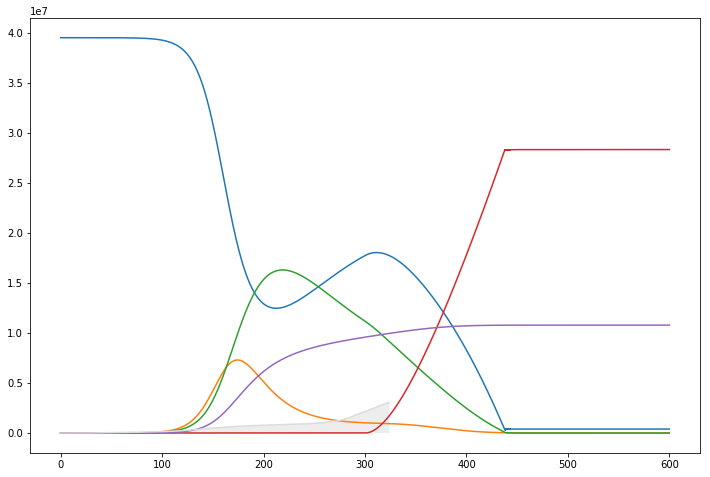

In [27]:
### Final plots? hopefully 

I0 = cases[0]
N = 39.5*10**6 # actual population of CA
k = 0.15
g = 1/14
v = N * 0.01
duration = 600 
r = 50
lag = 300 # from katherine from papers
A = 0.01
d = 0.016
dt = 0.001
w = 90

fig1, axs1 = plt.subplots()

x = np.linspace(0, duration, duration/dt)
S, I, R, H, D = SIRHD(I0, N, k, g, v, lag, r, A, d, w, dt, duration)
plt.plot(x, S, label = "S")
plt.plot(x, I, label = "I")
plt.plot(x, R, label = "R")
plt.plot(x, H, label = "H")
plt.plot(x, D, label = "D")

time = np.linspace(0,len(cases), len(cases))
axs1.plot(time[:len(cases)], cases, label = "Real case data", color = "gainsboro")
axs1.fill_between(time[:len(cases)], 0, cases, facecolor = "gainsboro", alpha = 0.5)

/Users/rebeccanishide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


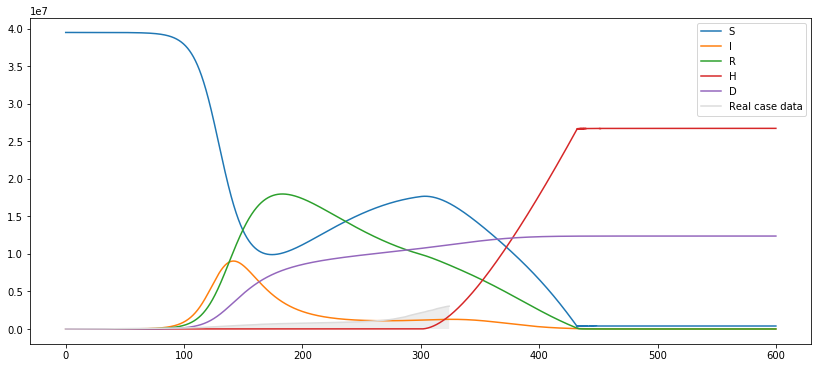

In [30]:
### Final plots? hopefully 

I0 = cases[0]
N = 39.5*10**6 # actual population of CA
k = 0.17
g = 1/14
v = N * 0.01
duration = 600 
r = 50
lag = 300 # from katherine from papers
A = 0.01
d = 0.016
dt = 0.001
w = 90

fig2, axs2 = plt.subplots()

x = np.linspace(0, duration, duration/dt)
S, I, R, H, D = SIRHD(I0, N, k, g, v, lag, r, A, d, w, dt, duration)
plt.plot(x, S, label = "S")
plt.plot(x, I, label = "I")
plt.plot(x, R, label = "R")
plt.plot(x, H, label = "H")
plt.plot(x, D, label = "D")

time = np.linspace(0,len(cases), len(cases))
axs2.plot(time[:len(cases)], cases, label = "Real case data", color = "gainsboro")
axs2.fill_between(time[:len(cases)], 0, cases, facecolor = "gainsboro", alpha = 0.5)
axs2.legend()